In [1]:
import pyift.pyift as ift
import numpy as np
import matplotlib.pyplot as plt
import sys

### Read a breast image with a carcinoma

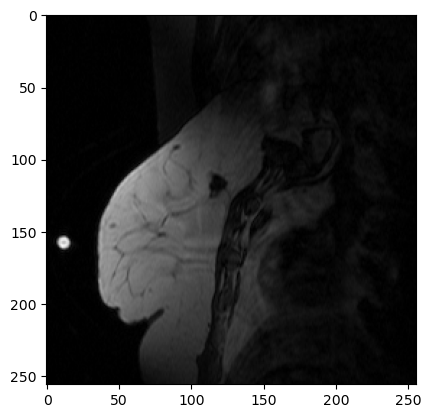

In [2]:
carcinoma = ift.ReadImageByExt("../data/carcinoma.png")
plt.imshow(carcinoma.ToPlot())
plt.show()

### Since the carcinoma is a dark region surrounded by brighter tissues, optimum paths from the image borders, whose maximum intensity is minimum along the path, will reach the carcinoma with higher values than the intensities inside the carcinoma. Such a filtering operation is called CloseBasins. The dual of this operator is called OpenDomes.

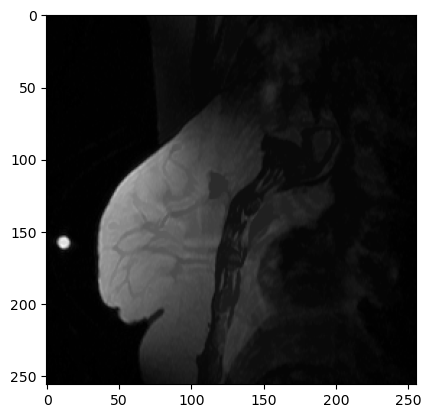

In [3]:
cbasins = ift.CloseBasins(carcinoma, None, None) # the second argument can be a seed set 
                                                 # and the third one can be a mask
plt.imshow(cbasins.ToPlot())
plt.show()    

### The residue of this operation will then enhance the carcinoma for a possible segmentation based on thresholding. However, similar regions outside the breast might be enhanced, creating false positives. They can be eliminated if we segment the breast as the largest component after thresholding, and use the resulting mask to select the residue inside the breast.  

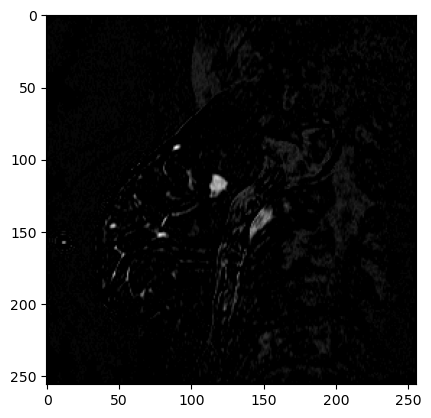

In [4]:
residue = ift.Sub(cbasins, carcinoma) # compute the residue
plt.imshow(residue.ToPlot())
plt.show() 

### Segment the breast as the largest component after thresholding within [0.7T,255], where T is Otsu's threshold.

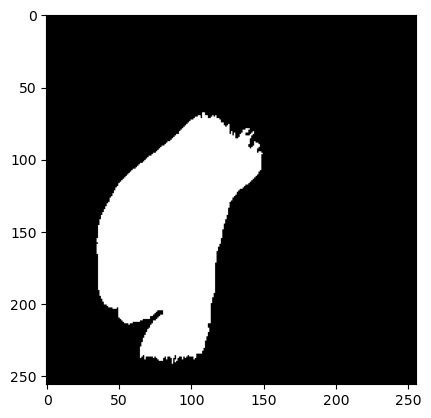

In [23]:
breast = ift.Threshold(cbasins, int(0.7*ift.Otsu(cbasins)), 255, 1) # the third argument is 
                                                             # the maximum intensity and
                                                             # the fourth one is the 
                                                             # output value 
breast = ift.SelectLargestComp(breast, None) # Select the largest component for a default 
                                             # 8-neighborhood adjacency (second argument)
plt.imshow(breast.ToPlot())
plt.show() 

### Use the resulting breast mask to isolate the carcinoma and segment it as the largest component with intensity [T,255], where T is the Otsu's threshold.

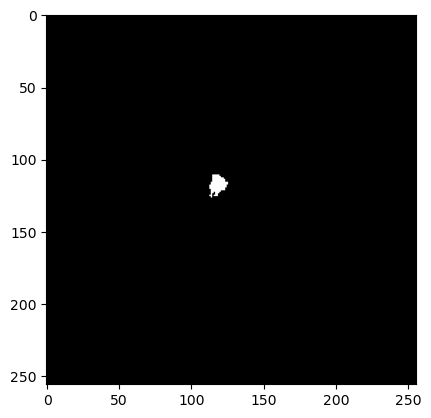

In [22]:
residue   = ift.Mask(residue, breast) # isolate the carcinoma
carcinoma = ift.Threshold(residue,ift.Otsu(residue),255,1)
carcinoma = ift.SelectLargestComp(carcinoma, None)
plt.imshow(carcinoma.ToPlot())
plt.show() 

### Read a blood cell image to count the number of cells

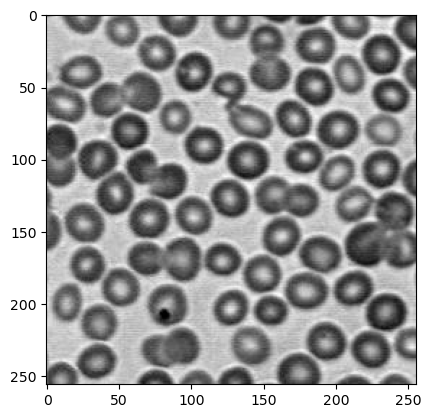

In [7]:
bloodcells = ift.ReadImageByExt("../data/bloodcells.png")
plt.imshow(bloodcells.ToPlot())
plt.show()

### Remove domes with area below 5000 pixels

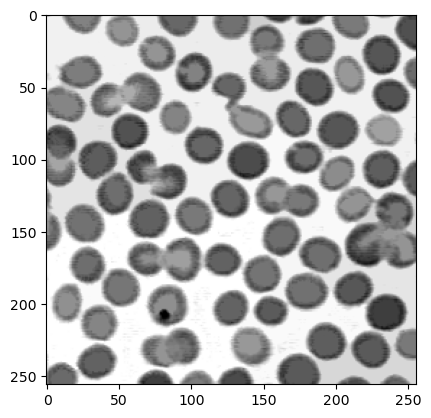

In [8]:
aopen  = ift.FastAreaOpen(bloodcells,5000) 
plt.imshow(aopen.ToPlot())
# OpenDomes creates a similar effect, but it is not the same operator
#odomes = ift.OpenDomes(bloodcells, None, None) 
#plt.imshow(aopen.ToPlot())
plt.show()

### Binarize the filtered image by Otsu's thresholding

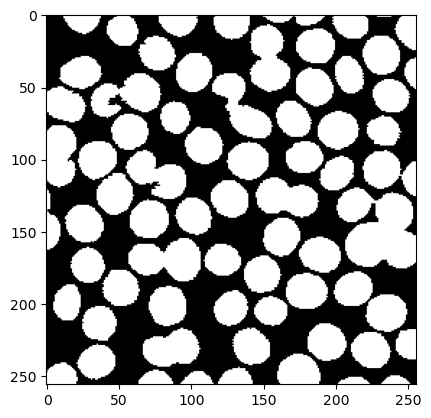

In [9]:
bincells = ift.Threshold(aopen,0,ift.Otsu(aopen),1)
#bincells = ift.Threshold(odomes,0,ift.Otsu(odomes),1)
plt.imshow(bincells.ToPlot())
plt.show()

###  Compute the Euclidean distance transform (the cost of a path is the Euclidean distance between its end points) inside the cells (option 0)

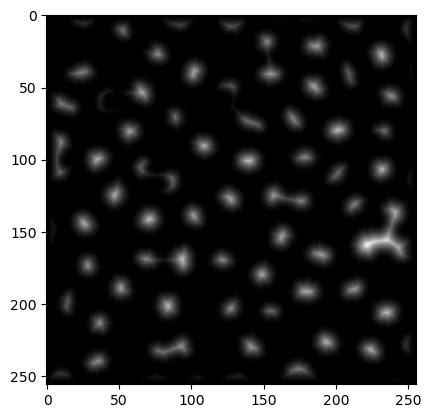

In [10]:
A   = ift.Circular(1.5)
edt = ift.EuclDistTrans(bincells, A, 0, None, None, None)
plt.imshow(edt[0].ToPlot())
plt.show()

### The regional maxima of the EDT can also be found as roots of an inferior reconstruction by IFT (h-domes for h=1). However, there might be more than one maximum per cell and this can be addressed by labeling maxima within distance 5.0 with the same label. 

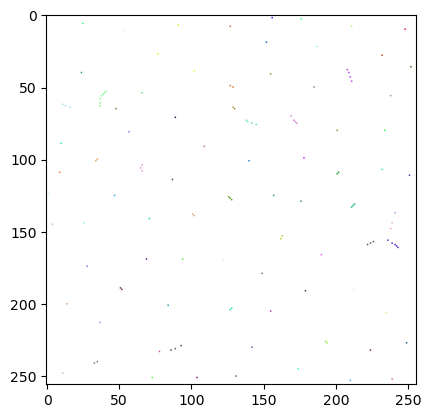

Number of cells (first estimate):  86


In [11]:
A     = ift.Circular(5.0)
rmax  = ift.RegionalMaxima(edt[0])
rmax  = ift.FastLabelComp(rmax,A)
crmax = ift.ColorizeComp(rmax)
plt.imshow(crmax.ToPlot())
plt.show()
print("Number of cells (first estimate): ", ift.MaximumValue(rmax))

### We can also delineate those cells by computing a watershed transform from those maxima and avoiding the background of the cells. 

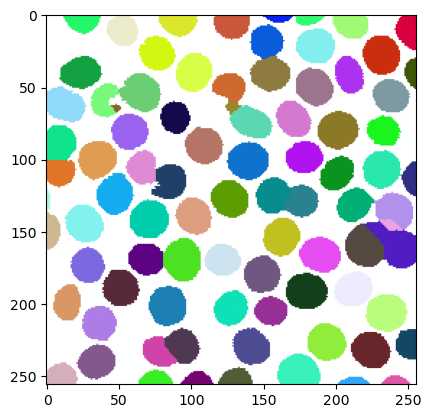

In [12]:
# Convert the seed image into a labeled set
S    = ift.LabeledSetFromSeedImage(rmax, False)
# Create a forbiden set whose pixels are the background of the cells
bkg  = ift.Complement(bincells) 
bkg  = ift.BinaryMaskToSet(bkg)
# Create a basins image as the complement of the EDT
basins = ift.Complement(edt[0])
# Compute the watershed transform
A      = ift.Circular(1.5)
label  = ift.Watershed(basins,A, S, bkg)
clabel = ift.ColorizeComp(label)
plt.imshow(clabel.ToPlot())
plt.show()

### Given that the above criterion was not enough to eliminate false seeds for cell separation, we can eliminate delineated components with area below the area of a typical cell. 

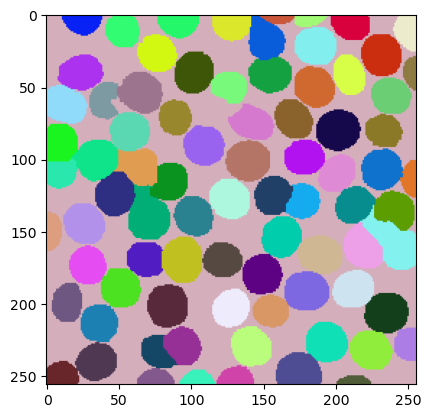

Number of cells (second estimate):  81


In [13]:
flabel = ift.SelectRegionsAboveAreaAndPropagateTheirLabels(label, 100)
clabel = ift.ColorizeComp(flabel)
plt.imshow(clabel.ToPlot())
plt.show()
print("Number of cells (second estimate): ", ift.MaximumValue(flabel)-1)